# Seq2seq와 Attention을 이용한 번역 모델

__할 일__
  - Luong attention 적용해보기
  - GRU 셀 바깥에 드롭아웃 적용
  - Sub-word로 토크나이징 해보기

__한 일__
  - 한글 형태소 토크나이저 적용
  - 인코더 패딩, 시퀀스 순서 뒤집기
  - 커스텀 LR 스케줄러
  - GRU 셀에 드롭아웃 적용

- w. unroll + dropout + LR scheduler -> 12 epoch training  
<!--   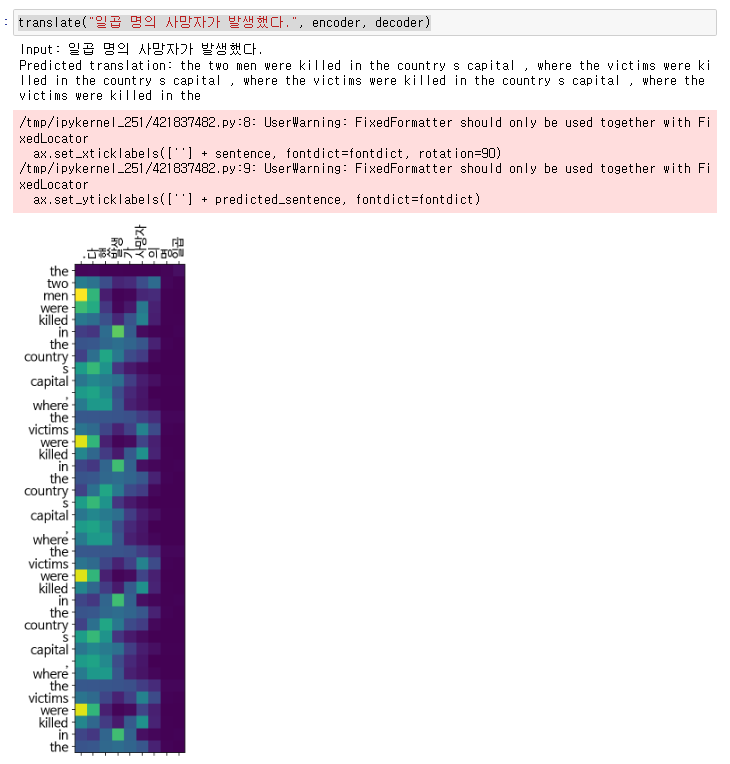 -->
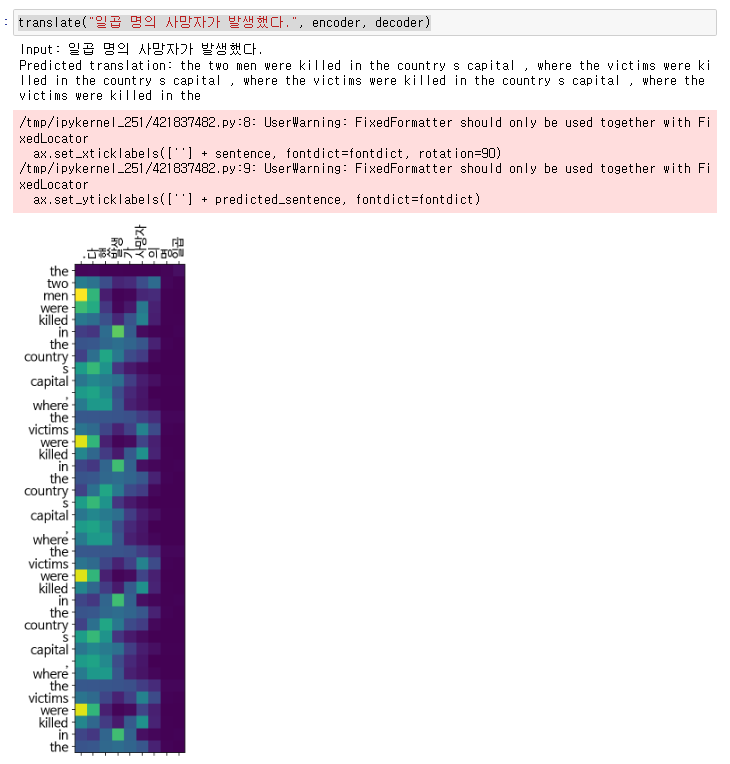
- w. unroll + dropout + LR scheduler -> 36 epoch training  
<!--   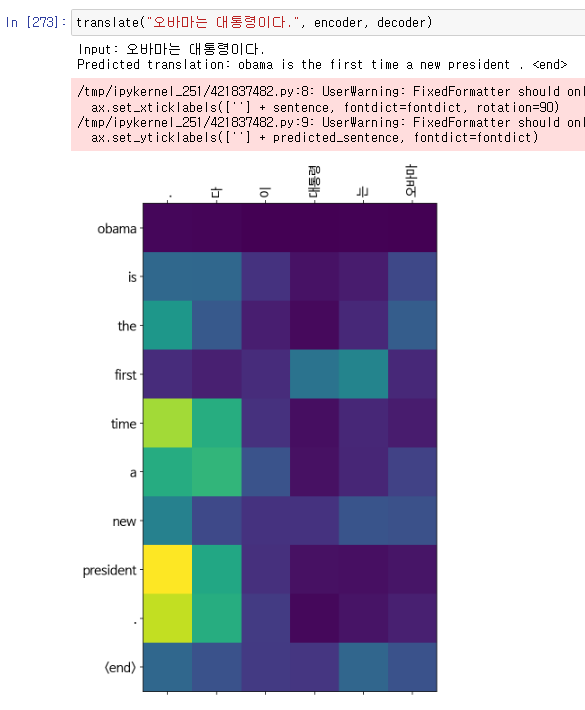 -->
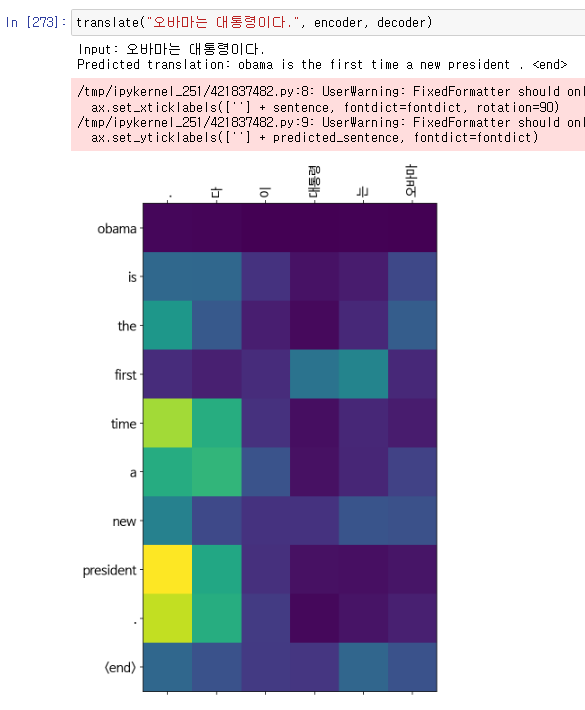

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

In [262]:
run_idx = 0

In [2]:
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io

print(tf.__version__)

2.6.0


In [3]:
kor_file = "/aiffel/aiffel/seq2seq_gd/korean-english-park.train.ko"
eng_file = "/aiffel/aiffel/seq2seq_gd/korean-english-park.train.en"

with open(kor_file, "r") as f:
    kor_raw = f.read().splitlines()

with open(eng_file, "r") as f:
    eng_raw = f.read().splitlines()

print("Data Size:", len(kor_raw), len(eng_raw))
print("Example:")

Data Size: 94123 94123
Example:


In [4]:
for sen in kor_raw[0:100][::20]: print(">>", sen)

>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


In [5]:
# 중복된 데이터를 제거
kor_eng_pairs = set(kor_eng for kor_eng in zip(kor_raw, eng_raw))
print("kor_eng_pairs: ", len(kor_eng_pairs))

kor_eng_pairs:  78968


In [132]:
def preprocess_sentence(sentence, lang='eng', s_token=False, e_token=False):
    
    if lang=='eng':
        sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence.lower())
    else:
        # (유니코드 문자열, ".", "?", "!", ",")를 제외한 모든 문자를 공백으로 대체
        # 한글은 유니코드에 포함되어 있고 낱소리만 쓰인 문자열도 포함됨
        sentence = re.sub(r'([^\w?.!,])', " ", sentence)
        
    sentence = sentence.strip()

    # 구두점(punctuation)을 토큰으로 인식하도록 단어와의 사이에 공백
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    sentence = re.sub(r'[" "]+', " ", sentence)
    
    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    return sentence

In [133]:
enc_corpus = []
dec_corpus = []

# num_examples = 30000

for pair in kor_eng_pairs:
    kor, eng = pair
    enc_corpus.append(preprocess_sentence(kor, lang='kor',))
    dec_corpus.append(preprocess_sentence(eng, s_token=True, e_token=True))

In [156]:
i=123; print("Korean:", enc_corpus[i],"\nEnglish:", dec_corpus[i])

Korean: 마츠자와 연구원을 포함 , 대학생 9명이 두 번째 테스트에 참여했다 . 
English: <start> researchers included him and nine college students in a second test . <end>


__snippet from GD 1st proj.__
```python
# 위에서 사용한 코드를 활용해 MeCab 단어 사전을 만들어보세요. 
# Hint : mecab.morphs()를 사용해서 형태소분석을 합니다.
def mecab_split(sentence):
    return mecab.morphs(sentence)

mecab_corpus = []

for kor in filtered_corpus:
    mecab_corpus.append(mecab_split(kor))

mecab_tensor, mecab_tokenizer = tokenize(mecab_corpus)

print("MeCab Vocab Size:", len(mecab_tokenizer.index_word))
mecab_tokenizer.sequences_to_texts([mecab_tensor[100]])
```

In [157]:
from konlpy.tag import Okt, Mecab
from collections import Counter
# okt = Okt()
mecab = Mecab()

def tokenize(corpus, anlyzr=None):
    #' analyzer=anlyzr' 인자는 이 TF 버전에선 지원 안 됨
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)
    
    return tensor, tokenizer

def tokenize_kor(corpus, anlyzr=mecab, sp_tkns=4):
    tkns = []
    for s in corpus:
        tkns.extend(anlyzr.morphs(s))
    
    tkn_cnts = Counter(tkns)
    
    index_word = ['<>']*sp_tkns; word_index = {}
    for i, t in enumerate(tkn_cnts.most_common()):
        index_word.append(t[0]); word_index[t[0]] = i+sp_tkns
    
    tensor = [[word_index[tkn] for tkn in anlyzr.morphs(s)] for s in corpus] 
    
    return tensor, index_word, word_index

In [158]:
def texts_to_sequences_kor(text, anlyzr=mecab, sp_tkns=4, r=True):
  return [ word_index_kor.get(tkn, sp_tkns-1) for tkn
                          in anlyzr.morphs(text) ][::1-int(r)*2]

def sequences_to_texts_kor(seq, sp_tkns=4, r=True):
  return [ index_word_kor[tkn] for tkn in seq ][::1-int(r)*2]

In [ ]:
X, index_word_kor, word_index_kor = tokenize_kor(enc_corpus)
y, dec_tokenizer = tokenize(dec_corpus)

In [162]:
enc_corpus[0]

'압바스는 이미 이스라엘에게 가능한 빨리 협상에 나서도록 종용하는 가 하면 아랍권 지도자들은 2002년 마련된 아랍평화안을 채택하도록 촉구하기도 했다 .'

In [212]:
print(texts_to_sequences_kor(enc_corpus[0]))

[4, 5, 14, 39, 35, 13, 587, 180, 13, 2863, 8, 149, 340, 2110, 47, 805, 41, 1045, 11, 17, 267, 343, 2110, 85, 13, 18, 7, 13, 11546, 180, 3543, 10, 300, 1982, 21, 202, 57, 206, 389, 7, 4043]


In [164]:
print(X[0])

[4043, 7, 389, 206, 57, 202, 21, 1982, 300, 10, 3543, 180, 11546, 13, 7, 18, 13, 85, 2110, 343, 267, 17, 11, 1045, 41, 805, 47, 2110, 340, 149, 8, 2863, 13, 180, 587, 13, 35, 39, 14, 5, 4]


In [165]:
X_over_cnt = 0
y_over_cnt = 0
over_cnt = 0
maxlen=40

for Xy in zip(X, y):
    if len(Xy[0])>maxlen: X_over_cnt+=1
    if len(Xy[1])>maxlen: y_over_cnt+=1        
    if min(len(Xy[0]), len(Xy[1]))>maxlen: over_cnt+=1        

In [166]:
print("Kor sentence with over {} token: ".format(maxlen),X_over_cnt)
print("Eng sentence with over {} token: ".format(maxlen),y_over_cnt)
print("both sentence with over {} token: ".format(maxlen),over_cnt)

Kor sentence with over 40 token:  14043
Eng sentence with over 40 token:  8727
both sentence with over 40 token:  5327


- 시퀀스 토큰수 필터링 후 패딩 진행; 텐서 변환 시도들

```python
enc_cleaned = np.empty(shape=(0, maxlen), dtype=np.uint16)
dec_cleaned = np.empty(shape=(0, maxlen), dtype=np.uint16)

# dec_cleaned = np.array((None, maxlen))
# dec_cleaned = tf.compat.v1.placeholder(tf.float32, (None, maxlen))

for Xy in zip(X, y):
  if len(Xy[1])>maxlen:
    enc_cleaned = np.concatenate(
          enc_cleaned, pad_sequences((Xy[0],), padding='pre', maxlen=maxlen) )
    dec_cleaned = np.concatenate(
          dec_cleaned, pad_sequences((Xy[1],), padding='pre', maxlen=maxlen) )
    
#     tf.concat(enc_cleaned, pad_sequences((Xy[0],), padding='pre', maxlen=maxlen))
#     tf.concat(dec_cleaned, pad_sequences((Xy[1],), padding='post', maxlen=maxlen))
    
#     enc_cleaned.extend(pad_sequences((Xy[0],), padding='pre', maxlen=40))
#     dec_cleaned.extend(pad_sequences((Xy[1],), padding='pre', maxlen=40))
```

In [167]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# 인코더는 역방향 입력/패딩
enc_cleaned = pad_sequences([Xy[0][::-1] for Xy in zip(X, y)if len(Xy[0])<=maxlen],
                            padding='pre', maxlen=maxlen)
dec_cleaned = pad_sequences([Xy[1] for Xy in zip(X, y)if len(Xy[0])<=maxlen],
                            padding='post', maxlen=maxlen)

enc_train, enc_val, dec_train, dec_val = train_test_split(
                                enc_cleaned, dec_cleaned, test_size=0.2, random_state=42)

print("enc_train: ", len(enc_train))
print("dec_train: ", len(dec_train))
print("enc_val: ", len(enc_val))
print("dec_val: ", len(dec_val))

enc_train:  51940
dec_train:  51940
enc_val:  12985
dec_val:  12985


In [168]:
print(enc_cleaned[0])

[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0   715  1211   954
     4 20956  5175  4965]


In [169]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

In [170]:
class Encoder(tf.keras.Model): # 예제코드 재사용
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True,
                                       unroll=True,
                                       dropout=0.4, recurrent_dropout=0.2,
                                      )
        
    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)
        
        return out

In [191]:
class Decoder(tf.keras.Model): # 예제코드 재사용
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       unroll=True,
                                       dropout=0.4, recurrent_dropout=0.2,
                                      )
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        
        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [192]:
BATCH_SIZE     = 64
SRC_VOCAB_SIZE = len(index_word_kor) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1

units         = 512 # 1024 절반
embedding_dim = 256 # 512 절반

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 30

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (64, 30, 512)
Decoder Output: (64, 44566)
Decoder Hidden State: (64, 512)
Attention: (64, 30, 1)


In [258]:
encoder.summary()

Model: "encoder_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      multiple                  13844480  
_________________________________________________________________
gru_8 (GRU)                  multiple                  1182720   
Total params: 15,027,200
Trainable params: 15,027,200
Non-trainable params: 0
_________________________________________________________________


In [259]:
decoder.summary()

Model: "decoder_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      multiple                  11408896  
_________________________________________________________________
gru_9 (GRU)                  multiple                  1969152   
_________________________________________________________________
dense_16 (Dense)             multiple                  22862358  
_________________________________________________________________
bahdanau_attention_4 (Bahdan multiple                  525825    
Total params: 36,766,231
Trainable params: 36,766,231
Non-trainable params: 0
_________________________________________________________________


In [196]:
@tf.function  # 예제코드 재사용
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bch_sz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bch_sz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss


In [197]:
@tf.function  # 예제코드 재사용
def eval_step(src, tgt, encoder, decoder, dec_tok):
    bch_sz = src.shape[0]
    loss = 0

    enc_out = encoder(src)

    h_dec = enc_out[:, -1]
    
    dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bch_sz, 1)

    for t in range(1, tgt.shape[1]):
        pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

        loss += loss_function(tgt[:, t], pred)
        dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))
    
    return batch_loss

In [193]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [194]:
D_MODEL= units # 512
L_RATE = 0.002 # 0.001
learning_rate = CustomSchedule(D_MODEL)

In [195]:
optimizer = tf.keras.optimizers.Adam(CustomSchedule(D_MODEL))
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

In [264]:
from tqdm import tqdm
import random
tf.config.run_functions_eagerly(False) # True

In [265]:
EPOCHS = 24

for epoch in range(EPOCHS):  # 예제코드 재사용
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE)) # 
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
    
    test_loss = 0
    
    idx_list = list(range(0, enc_val.shape[0], BATCH_SIZE)) # 
    random.shuffle(idx_list)
    t = tqdm(idx_list)
    
    for (test_batch, idx) in enumerate(t):
        test_batch_loss = eval_step(enc_val[idx:idx+BATCH_SIZE],
                                    dec_val[idx:idx+BATCH_SIZE],
                                    encoder,
                                    decoder,
                                    dec_tokenizer)
    
        test_loss += test_batch_loss

        t.set_description_str('Test Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy() / (test_batch + 1)))

Test Epoch 24: 100%|██████████| 203/203 [00:19<00:00, 10.29it/s, Test Loss 3.3035]


```
Epoch  1: 100%|██████████| 831/831 [04:52<00:00,  2.84it/s, Loss 4.1764]
Test Epoch  1: 100%|██████████| 208/208 [00:42<00:00,  4.93it/s, Test Loss 4.1379]
Epoch  2: 100%|██████████| 831/831 [03:51<00:00,  3.58it/s, Loss 4.1312]
Test Epoch  2: 100%|██████████| 208/208 [00:19<00:00, 10.55it/s, Test Loss 4.1458]
Epoch  3: 100%|██████████| 831/831 [03:55<00:00,  3.53it/s, Loss 4.1321]
Test Epoch  3: 100%|██████████| 208/208 [00:19<00:00, 10.49it/s, Test Loss 4.1464]

#w. unroll
Epoch  1: 100%|██████████| 831/831 [04:00<00:00,  3.46it/s, Loss 4.3313]
Test Epoch  1: 100%|██████████| 208/208 [00:29<00:00,  7.05it/s, Test Loss 4.3023]
Epoch  2: 100%|██████████| 831/831 [03:40<00:00,  3.77it/s, Loss 4.3041]
Test Epoch  2: 100%|██████████| 208/208 [00:18<00:00, 11.39it/s, Test Loss 4.3210]
Epoch  3: 100%|██████████| 831/831 [03:42<00:00,  3.73it/s, Loss 4.3130]
Test Epoch  3: 100%|██████████| 208/208 [00:18<00:00, 11.38it/s, Test Loss 4.3230]

#w. unroll + dropout
Epoch  1: 100%|██████████| 812/812 [04:49<00:00,  2.80it/s, Loss 4.2823]  
Test Epoch  1: 100%|██████████| 203/203 [00:36<00:00,  5.61it/s, Test Loss 4.2794]
Epoch  2: 100%|██████████| 812/812 [03:56<00:00,  3.44it/s, Loss 4.2542]
Test Epoch  2: 100%|██████████| 203/203 [00:19<00:00, 10.67it/s, Test Loss 4.3065]
Epoch  3: 100%|██████████| 812/812 [03:56<00:00,  3.44it/s, Loss 4.2626]
Test Epoch  3: 100%|██████████| 203/203 [00:18<00:00, 10.69it/s, Test Loss 4.3034]
Epoch  1: 100%|██████████| 812/812 [03:54<00:00,  3.46it/s, Loss 4.2605]
Test Epoch  1: 100%|██████████| 203/203 [00:18<00:00, 10.76it/s, Test Loss 4.3098]
Epoch  2: 100%|██████████| 812/812 [03:56<00:00,  3.44it/s, Loss 4.2624]
Test Epoch  2: 100%|██████████| 203/203 [00:18<00:00, 10.73it/s, Test Loss 4.3238]
Epoch  3: 100%|██████████| 812/812 [03:56<00:00,  3.44it/s, Loss 4.2624]
Test Epoch  3: 100%|██████████| 203/203 [00:18<00:00, 10.71it/s, Test Loss 4.3153]
Epoch  1: 100%|██████████| 812/812 [03:55<00:00,  3.44it/s, Loss 4.2630]
Test Epoch  1: 100%|██████████| 203/203 [00:18<00:00, 10.72it/s, Test Loss 4.3148]
Epoch  2: 100%|██████████| 812/812 [03:56<00:00,  3.44it/s, Loss 4.2617]
Test Epoch  2: 100%|██████████| 203/203 [00:18<00:00, 10.72it/s, Test Loss 4.3269]
Epoch  3: 100%|██████████| 812/812 [03:56<00:00,  3.44it/s, Loss 4.2624]
Test Epoch  3: 100%|██████████| 203/203 [00:19<00:00, 10.67it/s, Test Loss 4.3395]
Epoch  4: 100%|██████████| 812/812 [03:56<00:00,  3.44it/s, Loss 4.2615]
Test Epoch  4: 100%|██████████| 203/203 [00:19<00:00, 10.61it/s, Test Loss 4.3275]
Epoch  5: 100%|██████████| 812/812 [03:56<00:00,  3.44it/s, Loss 4.2624]
Test Epoch  5: 100%|██████████| 203/203 [00:19<00:00, 10.66it/s, Test Loss 4.3361]
Epoch  6: 100%|██████████| 812/812 [03:56<00:00,  3.44it/s, Loss 4.2618]
Test Epoch  6: 100%|██████████| 203/203 [00:18<00:00, 10.69it/s, Test Loss 4.3460]

#w. unroll + dropout + LR scheduler
Epoch  1: 100%|██████████| 812/812 [04:53<00:00,  2.77it/s, Loss 4.3973]  
Test Epoch  1: 100%|██████████| 203/203 [00:37<00:00,  5.43it/s, Test Loss 3.9699]
Epoch  2: 100%|██████████| 812/812 [04:03<00:00,  3.34it/s, Loss 3.7731]
Test Epoch  2: 100%|██████████| 203/203 [00:19<00:00, 10.37it/s, Test Loss 3.6686]
Epoch  3: 100%|██████████| 812/812 [04:03<00:00,  3.33it/s, Loss 3.5162]
Test Epoch  3: 100%|██████████| 203/203 [00:19<00:00, 10.20it/s, Test Loss 3.4505]
Epoch  4: 100%|██████████| 812/812 [04:04<00:00,  3.33it/s, Loss 3.3127]
Test Epoch  4: 100%|██████████| 203/203 [00:19<00:00, 10.35it/s, Test Loss 3.2998]
Epoch  5: 100%|██████████| 812/812 [04:03<00:00,  3.33it/s, Loss 3.1604]
Test Epoch  5: 100%|██████████| 203/203 [00:19<00:00, 10.32it/s, Test Loss 3.2109]
Epoch  6: 100%|██████████| 812/812 [04:04<00:00,  3.32it/s, Loss 3.0370]
Test Epoch  6: 100%|██████████| 203/203 [00:19<00:00, 10.22it/s, Test Loss 3.1543]
Epoch  1: 100%|██████████| 812/812 [04:03<00:00,  3.34it/s, Loss 2.9356]
Test Epoch  1: 100%|██████████| 203/203 [00:19<00:00, 10.25it/s, Test Loss 3.1198]
Epoch  2: 100%|██████████| 812/812 [04:04<00:00,  3.32it/s, Loss 2.8499]
Test Epoch  2: 100%|██████████| 203/203 [00:19<00:00, 10.26it/s, Test Loss 3.1020]
Epoch  3: 100%|██████████| 812/812 [04:04<00:00,  3.32it/s, Loss 2.7723]
Test Epoch  3: 100%|██████████| 203/203 [00:19<00:00, 10.31it/s, Test Loss 3.0732]
Epoch  4: 100%|██████████| 812/812 [04:04<00:00,  3.32it/s, Loss 2.6911]
Test Epoch  4: 100%|██████████| 203/203 [00:19<00:00, 10.24it/s, Test Loss 3.0432]
Epoch  5: 100%|██████████| 812/812 [04:04<00:00,  3.32it/s, Loss 2.6087]
Test Epoch  5: 100%|██████████| 203/203 [00:19<00:00, 10.34it/s, Test Loss 3.0214]
Epoch  6: 100%|██████████| 812/812 [04:05<00:00,  3.31it/s, Loss 2.5343]
Test Epoch  6: 100%|██████████| 203/203 [00:19<00:00, 10.30it/s, Test Loss 3.0079]

```

In [266]:
save_path ='/aiffel/aiffel/seq2seq_gd/checkpoints/'; run_idx += 1
encoder.save_weights(save_path+'encoder_checkpoint_{:0>3}'.format(run_idx))
encoder.save_weights(save_path+'decoder_checkpoint_{:0>3}'.format(run_idx))

In [267]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))
    
    sentence = preprocess_sentence(sentence, lang='kor')
    # 추가로 정의 된 'texts_to_sequences_kor' 함수 호출
    input_seq = texts_to_sequences_kor(sentence)
    inputs = tf.keras.preprocessing.sequence.pad_sequences(
                        [input_seq], maxlen=enc_train.shape[-1], padding='pre')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_train.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, input_seq, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, input_seq, attention

In [268]:
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [269]:
def translate(sentence, encoder, decoder, verbose=False):
    result, sent_seq, attention = evaluate(sentence, encoder, decoder)
    if verbose: print("sent_seq1: ", sent_seq)
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    sent_seq = sequences_to_texts_kor(sent_seq, r=False)
    if verbose: print("sent_seq2: ", sent_seq)
    attention = attention[:len(result.split()), :len(sent_seq)]
    plot_attention(attention, sent_seq, result.split(' '))

Input: 커피 한 잔 주시겠어요?
Predicted translation: i don t know what i was a little bit . <end> 


/tmp/ipykernel_251/421837482.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_251/421837482.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


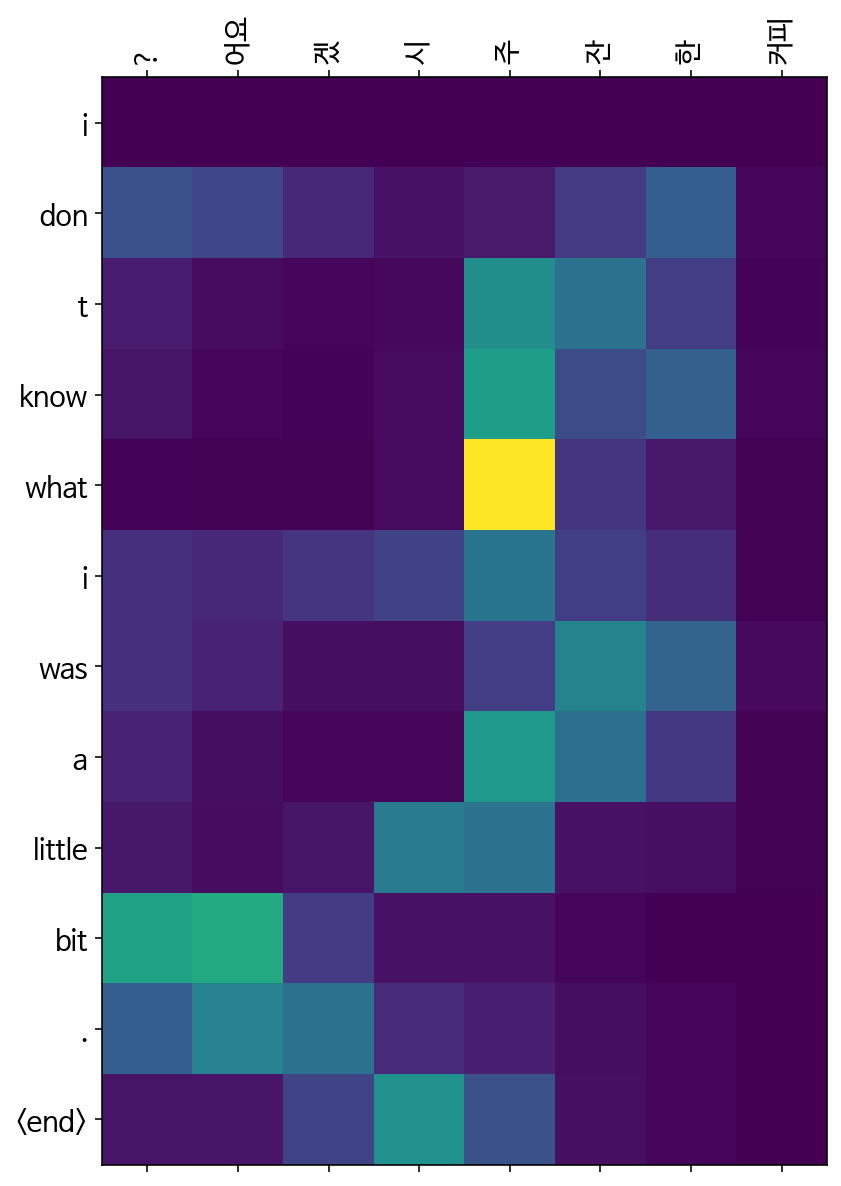

In [270]:
# translate("Can I have some coffee?", encoder, decoder)
translate("커피 한 잔 주시겠어요?", encoder, decoder)

Input: 사랑
Predicted translation: and pax jolie pitt has a confession to get a little trick <end> 


/tmp/ipykernel_251/421837482.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_251/421837482.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


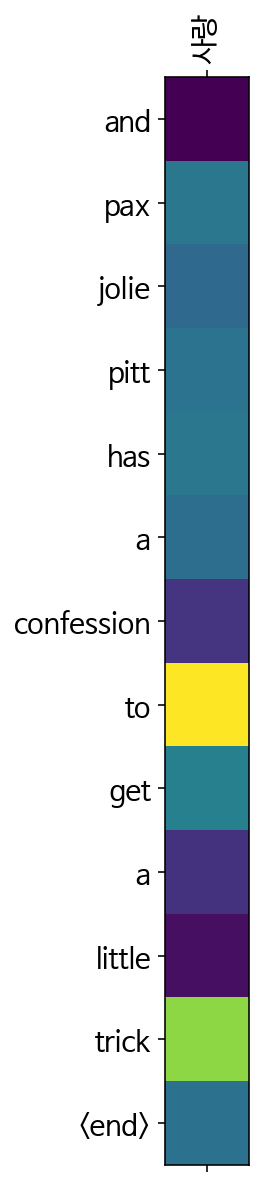

In [271]:
translate("사랑", encoder, decoder)

Input: 식사 커피 집 자동차 노래 음악.
Predicted translation: the nba has a tensile strength problem . <end> 


/tmp/ipykernel_251/421837482.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_251/421837482.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


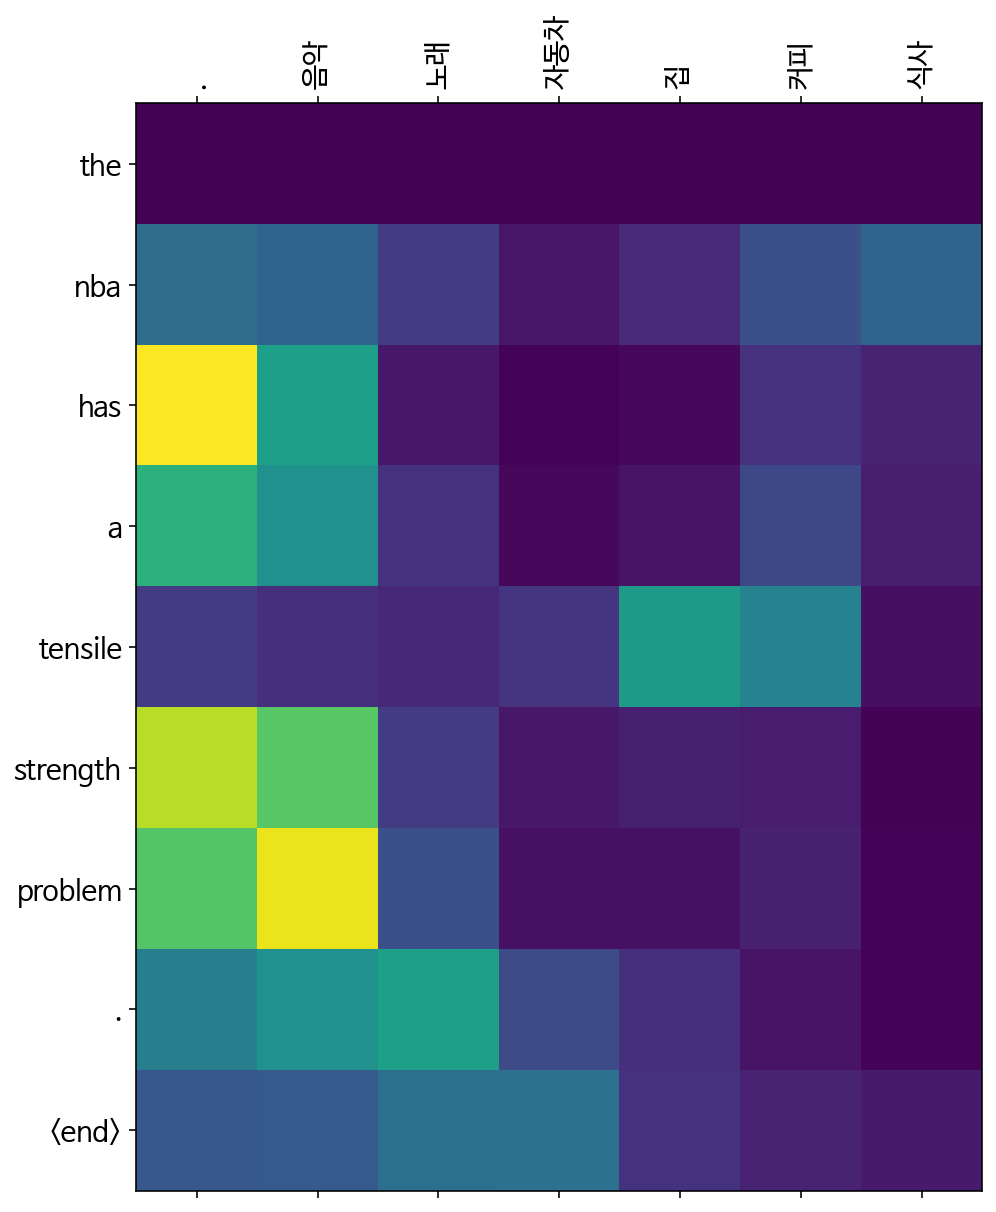

In [272]:
translate("식사 커피 집 자동차 노래 음악.", encoder, decoder)

Input: 오바마는 대통령이다.
Predicted translation: obama is the first time a new president . <end> 


/tmp/ipykernel_251/421837482.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_251/421837482.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


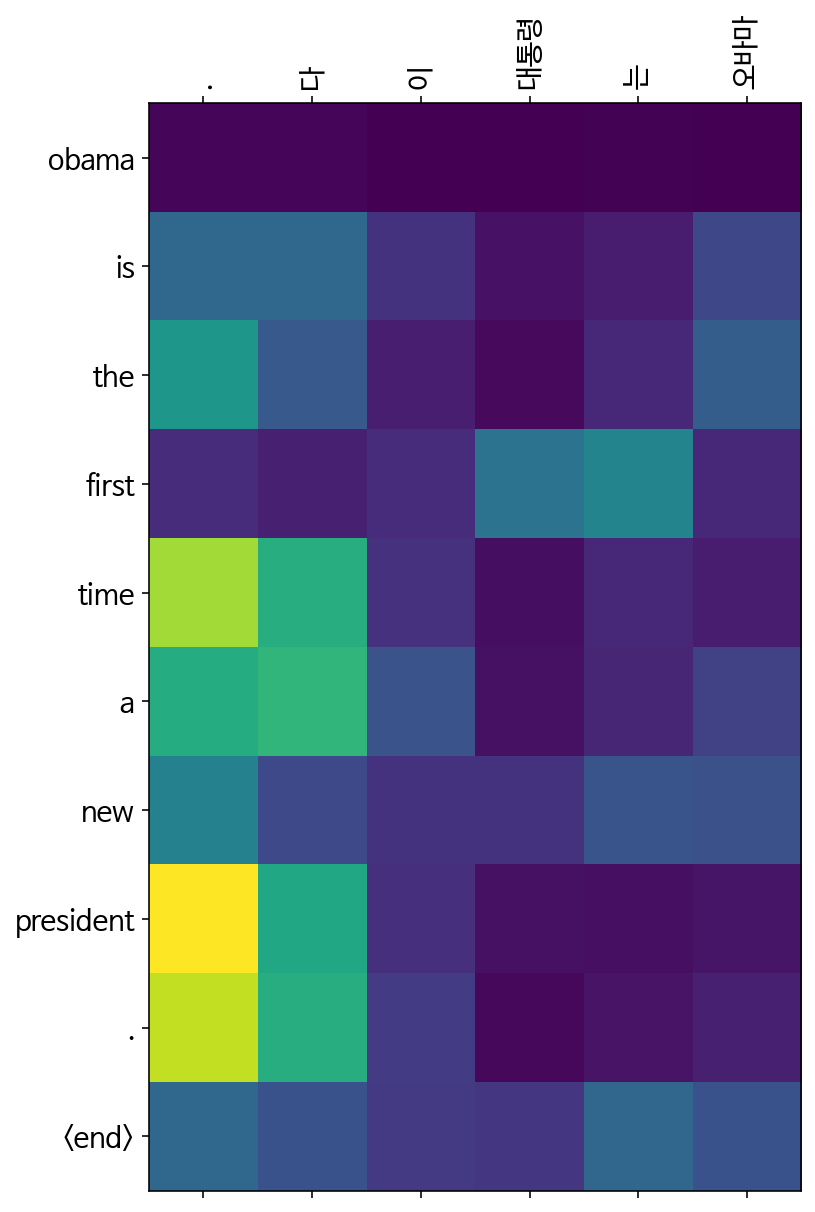

In [273]:
translate("오바마는 대통령이다.", encoder, decoder)

Input: 시민들은 도시 속에 산다.
Predicted translation: some of the dead mountaineers are being frayed <end> 


/tmp/ipykernel_251/421837482.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_251/421837482.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


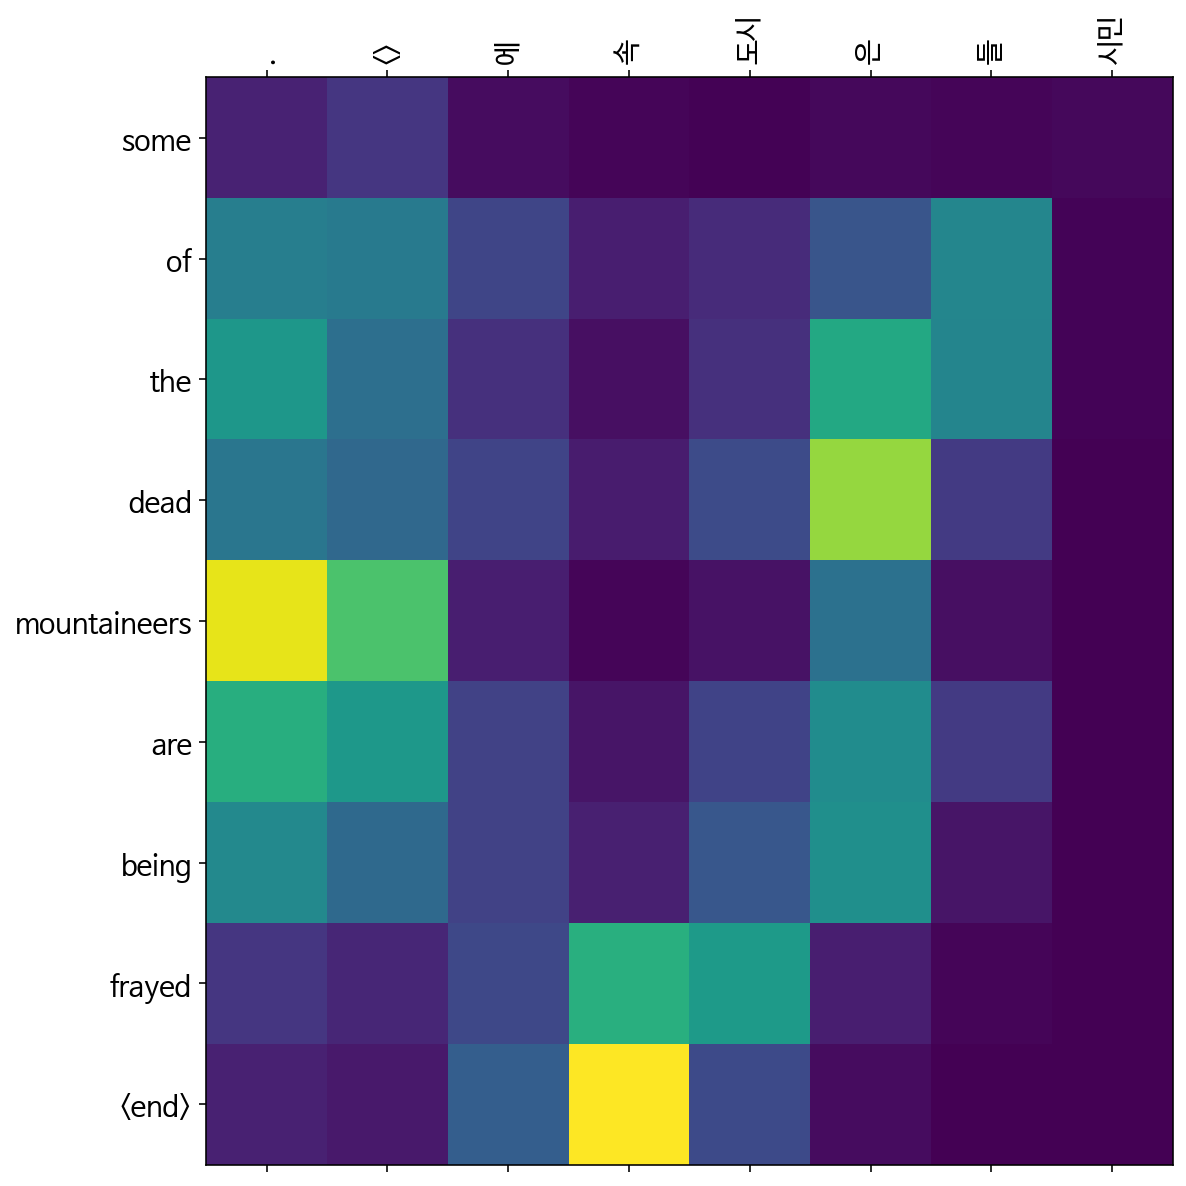

In [274]:
translate("시민들은 도시 속에 산다.", encoder, decoder)

Input: 커피는 필요 없다.
Predicted translation: it s a very important psychological of the world . <end> 


/tmp/ipykernel_251/421837482.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_251/421837482.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


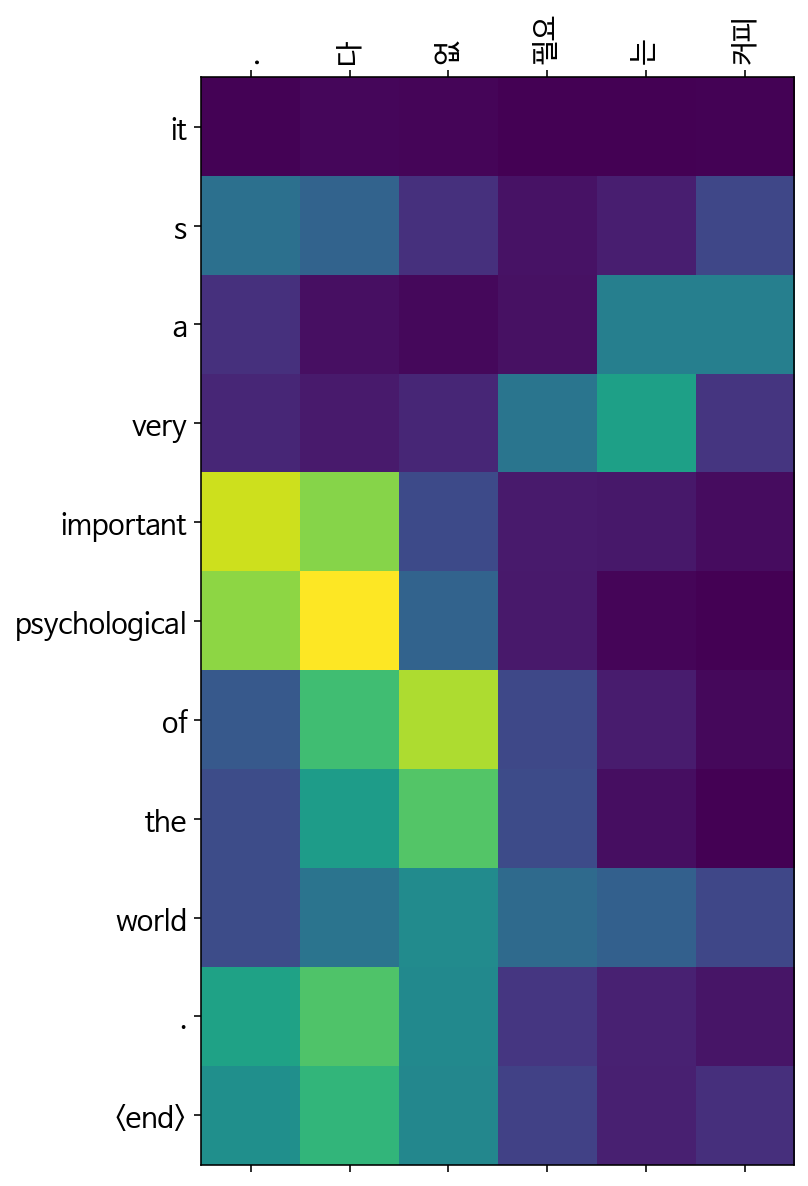

In [275]:
translate("커피는 필요 없다.", encoder, decoder)

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: two people were killed . <end> 


/tmp/ipykernel_251/421837482.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_251/421837482.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


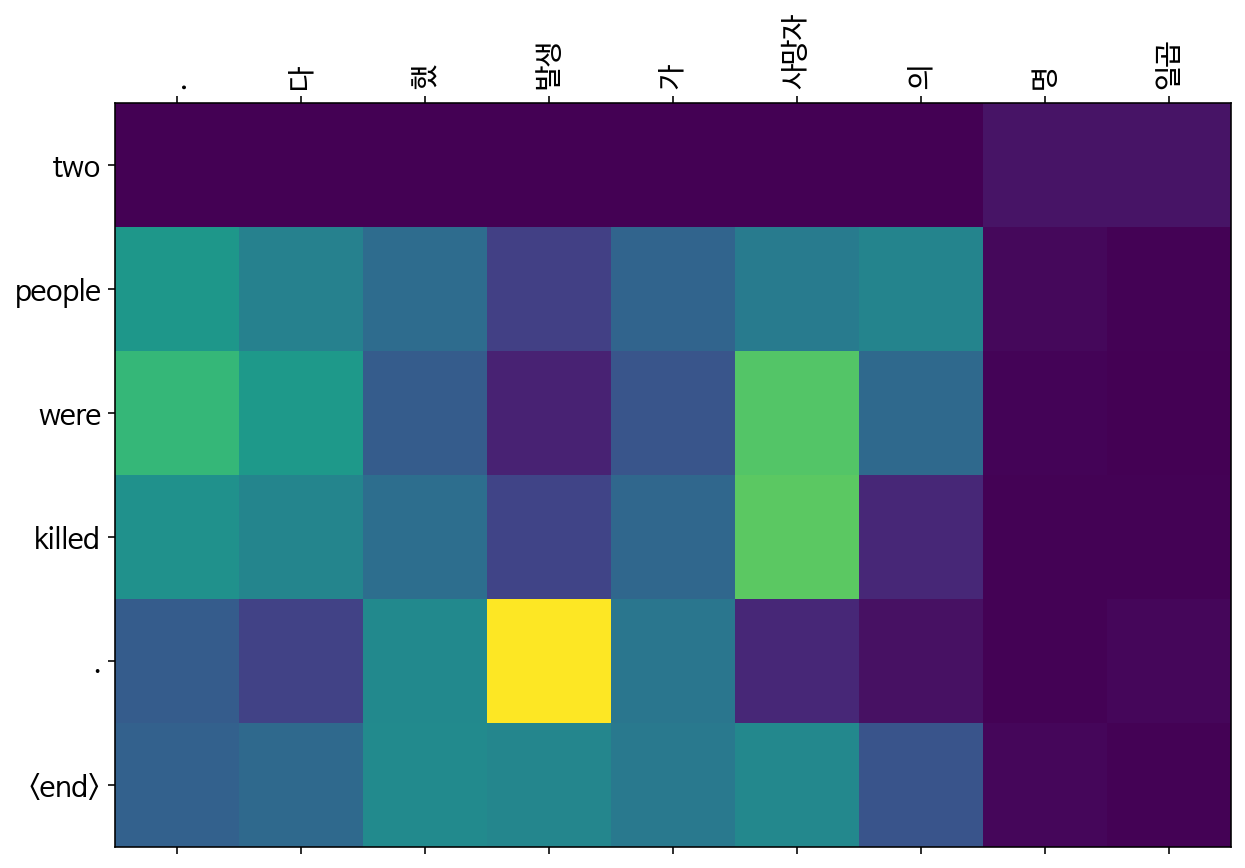

In [276]:
translate("일곱 명의 사망자가 발생했다.", encoder, decoder)

Input: 압바스는 이미 이스라엘에게 가능한 빨리 협상에 나서도록 종용하는 가 하면 아랍권 지도자들은 2002년 마련된 아랍평화안을 채택하도록 촉구하기도 했다
Predicted translation: hamas , which has been uncooperative in a dispute between the united states . <end> 


/tmp/ipykernel_251/421837482.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_251/421837482.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


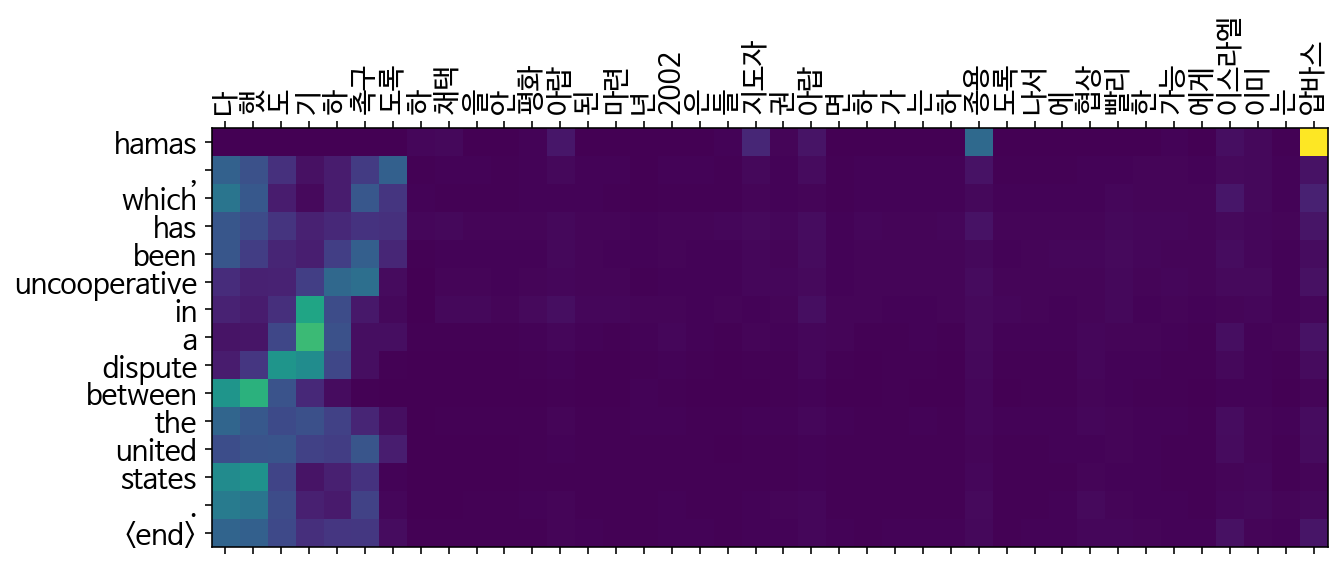

In [277]:
translate(enc_corpus[0][:-2], encoder, decoder)